In [ ]:
using Pkg

Pkg.add("SegyIO")
Pkg.add("Interpolations")
Pkg.add("Plots")
Pkg.add("HDF5")
Pkg.add("DelimitedFiles")
Pkg.add("ImageFiltering")
Pkg.add("Statistics")

In [7]:
using SegyIO
using Interpolations
using PyCall
using Plots
using HDF5
using DelimitedFiles
using ImageFiltering
using Statistics

1) Initial data

In [20]:
data_dir_in = "$(pwd())/.."
data_dir_out = "$(pwd())/initial_model"
mkpath(data_dir_out)

prestk_file = "seismic.segy"
model_file_out = "$(data_dir_out)/model.h5"
model_vvsp_png_out = "$(data_dir_out)/model_vvsp.png"
model_vlog_png_out = "$(data_dir_out)/model_vlog.png"
model_rho_png_out = "$(data_dir_out)/model_rho.png"

well4_blk_file = "$(data_dir_in)/well4.blk"
well4_blk_file_skip_lines = 4
well4_q_file = "$(data_dir_in)/well4.Q"
well4_q_file_skip_lines = 8
w4_cdp = 808
well5_blk_file = "$(data_dir_in)/well5.blk"
well5_blk_file_skip_lines = 4
well5_q_file = "$(data_dir_in)/well5.Q"
well5_q_file_skip_lines = 8
w5_cdp = 1572
well7_q_file = "$(data_dir_in)/well7.Q"
well7_q_file_skip_lines = 9
w7_cdp = 548

seabed = 0.355  # [km]

0.355

2) Initial params

In [10]:
# water velocity, km/s
vwater = 1.45

# water density, g/cm^3
rhowater = 1.02

# restric velocity model
vmin = vwater
vmax = 6.2

# depth domain velocity model settings (in km)
z0 = 0.f0
dz = 0.0125 # km
nz = 500

# z in km, t in seconds, v in km/s
z = z0:dz:(nz-1)*dz
dense_factor = 1f0  # make vel model n times denser

# smooth
smooth_radius = 10

10

3) Prepare X and T coordinates

In [11]:
container = segy_scan(data_dir_in, prestk_file, ["SourceX", "SourceY", "GroupX", "GroupY", "RecGroupElevation", "SourceSurfaceElevation", "dt"])
srcx = Float32.(get_header(container, "SourceX")[:,1])
grpx = Float32.(get_header(container, "GroupX")[:,1])
min_src_x = minimum(srcx)./1000f0
max_src_x = maximum(srcx)./1000f0
min_grp_x = minimum(grpx)./1000f0
max_grp_x = maximum(grpx)./1000f0
min_cdp_x = (min_src_x+min_grp_x)/2f0
max_cdp_x = (max_src_x+max_grp_x)/2f0
min_x = minimum([min_src_x, min_grp_x])
max_x = maximum([max_src_x, max_grp_x])
dx = 0.0125 # km
x = min_x:dx:max_x
nx = length(x)
cdp_x = min_cdp_x:dx:max_cdp_x
w4_cdp_x = cdp_x[w4_cdp]
w5_cdp_x = cdp_x[w5_cdp]
w7_cdp_x = cdp_x[w7_cdp]
nsamp = container.ns
dt = container.blocks[1].summary["dt"][1]/1.0e6
t = 0:dt:(nsamp-1)*dt
display("w4_cdp_x: $w4_cdp_x")
display("w5_cdp_x: $w5_cdp_x")
display("w7_cdp_x: $w7_cdp_x")
display("min_cdp_x: $min_cdp_x")
display("max_cdp_x: $max_cdp_x")
display("min_x: $min_x")
display("max_x: $max_x")
display("nx: $nx")
display("nsamp: $nsamp")
display("dt: $dt")
display("cdp_x: $cdp_x")

"w4_cdp_x: 11.705999994277954"

"w5_cdp_x: 21.255999994277953"

"w7_cdp_x: 8.455999994277954"

"min_cdp_x: 1.6185"

"max_cdp_x: 26.8935"

"min_x: 0.0"

"max_x: 28.512"

"nx: 2281"

"nsamp: 1500"

"dt: 0.004"

"cdp_x: 1.618499994277954:0.0125:26.880999994277953"

Scanning ... /home/kerim/Documents/Colada/r/julia-1.6/.julia/dev/JUDI/examples/field_data/viking_graben_line12/fwi/../seismic.segy


4) Read well data

In [12]:
# w4_blk 69x4 matrix: Depth (m)   Vp (m/s)    Vs (m/s)  Density (kg/m^3)  (w4 is located in the MIDDLE)
w4_blk = readdlm(well4_blk_file,skipstart=well4_blk_file_skip_lines)
# w4_q 100x4 matrix: Depth (m)   OWT (SECONDS)    TWT (ms)  Q
w4_q = reverse(readdlm(well4_q_file,skipstart=well4_q_file_skip_lines), dims=1)
w4_q = [0.0 0.0 0.0 w4_q[1,end]; w4_q]
q_unique_z_ind = findfirst.(isequal.(unique(w4_q[:,3])), [w4_q[:,3]])
w4_q = w4_q[q_unique_z_ind,:]
q_sort_ind = sortperm(w4_q[:,3])
w4_q = w4_q[q_sort_ind,:]
# w5_blk 50 matrix: Depth (m)   Vp (m/s)    Vs (m/s)  Density (kg/m^3)    (w5 is located at RIGHT)
w5_blk = readdlm(well5_blk_file,skipstart=well5_blk_file_skip_lines)
# Density is incorrect in well 5
w5_blk[2:34,4] = LinRange(w5_blk[2,4],w5_blk[34,4],33)
# w5_q 146x4 matrix: Depth (m)   OWT (SECONDS)    TWT (ms)  Q
w5_q = reverse(readdlm(well5_q_file,skipstart=well5_q_file_skip_lines), dims=1)
w5_q = [0.0 0.0 0.0 w5_q[1,end]; w5_q]
q_unique_z_ind = findfirst.(isequal.(unique(w5_q[:,3])), [w5_q[:,3]])
w5_q = w5_q[q_unique_z_ind,:]
q_sort_ind = sortperm(w5_q[:,3])
w5_q = w5_q[q_sort_ind,:]
# w7_q 146x4 matrix: Depth (m)   OWT (SECONDS)    TWT (ms)  Q
w7_q = reverse(readdlm(well7_q_file,skipstart=well7_q_file_skip_lines), dims=1)
w7_q = [0.0 0.0 0.0 w7_q[1,end]; w7_q]
q_unique_z_ind = findfirst.(isequal.(unique(w7_q[:,3])), [w7_q[:,3]])
w7_q = w7_q[q_unique_z_ind,:]
q_sort_ind = sortperm(w7_q[:,3])
w7_q = w7_q[q_sort_ind,:]

81×4 Matrix{Float64}:
    0.0  0.0       0.0  141.679
  960.0  0.54   1080.0  141.679
  976.0  0.549  1098.0  128.187
  996.0  0.559  1118.0  117.912
 1016.0  0.568  1136.0  124.371
 1260.0  0.692  1384.0  149.579
 1280.0  0.702  1404.0  146.007
 1300.0  0.711  1422.0  141.231
 1320.0  0.72   1440.0  140.544
 1340.0  0.729  1458.0  143.032
    ⋮                   
 2440.0  1.114  2228.0   73.498
 2460.0  1.12   2240.0   74.19
 2480.0  1.127  2254.0   76.289
 2490.0  1.129  2258.0   72.609
 2500.0  1.132  2264.0   72.746
 2510.0  1.135  2270.0   71.793
 2520.0  1.138  2276.0   72.02
 2530.0  1.141  2282.0   77.538
 2550.0  1.144  2288.0   80.077

5) Interpolate velocity (VSP) model

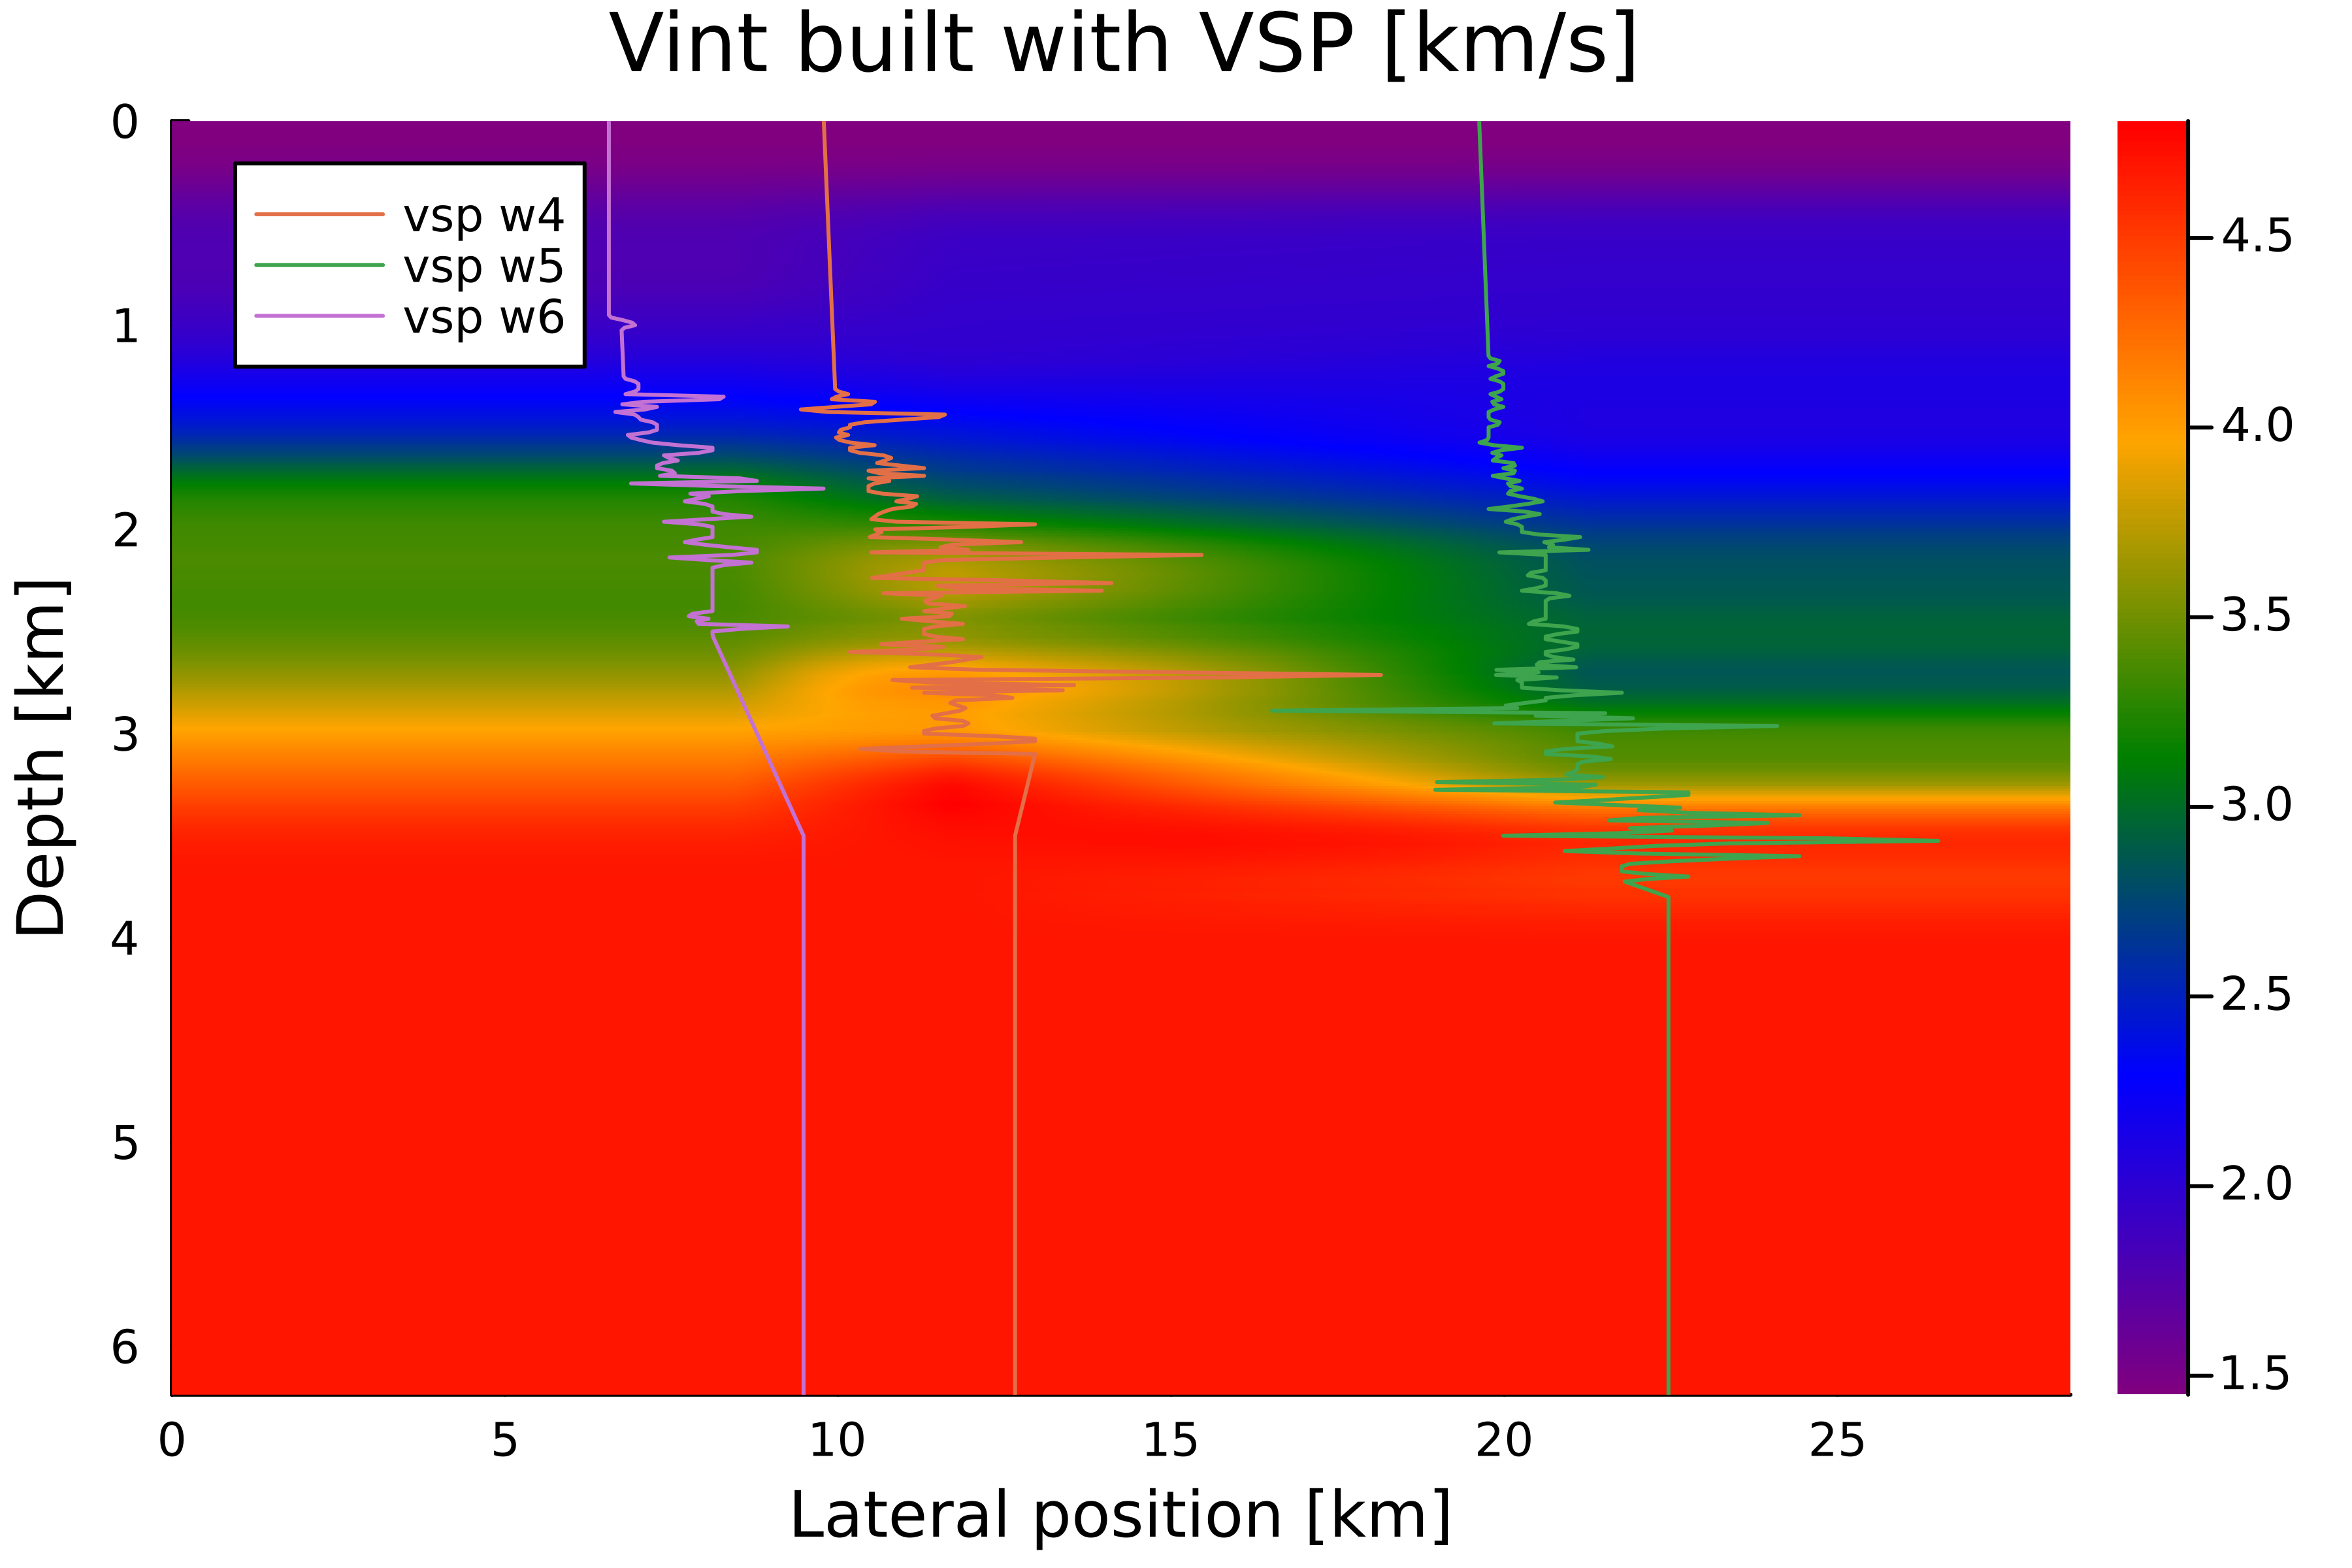

"/home/kerim/Documents/Colada/r/julia-1.6/.julia/dev/JUDI/examples/field_data/viking_graben_line12/fwi/initial_model/model_vvsp.png"

In [21]:
itp4 = LinearInterpolation(w4_q[:,3]./1000f0, w4_q[:,1]./1000f0, extrapolation_bc=Line())
w4_q_z = itp4(t)
itp5 = LinearInterpolation(w5_q[:,3]./1000f0, w5_q[:,1]./1000f0, extrapolation_bc=Line())
w5_q_z = itp5(t)
itp7 = LinearInterpolation(w7_q[:,3]./1000f0, w7_q[:,1]./1000f0, extrapolation_bc=Line())
w7_q_z = itp7(t)

# km/s
w4_q_z_last = 3.5f0
w4_q_v_last = 4.7f0
w5_q_z_last = 3.8f0
w5_q_v_last = 4.7f0
w7_q_z_last = 3.5f0
w7_q_v_last = 4.7f0

q_sort_ind = sortperm(w4_q[1:end,1])
w4_q_v = diff(w4_q[q_sort_ind,1])./diff(w4_q[q_sort_ind,3])*2.0
itp4_v = LinearInterpolation([w4_q[q_sort_ind[1:end-1],1]./1000f0; w4_q_z_last], [w4_q_v; w4_q_v_last], extrapolation_bc=w4_q_v_last)
w4_q_v = itp4_v(z)
q_sort_ind = sortperm(w5_q[1:end,1])
w5_q_v = diff(w5_q[q_sort_ind,1])./diff(w5_q[q_sort_ind,3])*2.0
itp5_v = LinearInterpolation([w5_q[q_sort_ind[1:end-1],1]./1000f0; w5_q_z_last], [w5_q_v; w5_q_v_last], extrapolation_bc=w5_q_v_last)
w5_q_v = itp5_v(z)
q_sort_ind = sortperm(w7_q[1:end-1,1])
w7_q_v = diff(w7_q[q_sort_ind,1])./diff(w7_q[q_sort_ind,3])*2.0
itp7_v = LinearInterpolation([w7_q[q_sort_ind[1:end-1],1]./1000f0; w7_q_z_last], [w7_q_v; w7_q_v_last], extrapolation_bc=w7_q_v_last)
w7_q_v = itp7_v(z)

itp = LinearInterpolation((vcat(x[1], w7_cdp_x, w4_cdp_x, w5_cdp_x, x[end]), z), [w7_q_v w7_q_v w4_q_v w5_q_v w5_q_v]', extrapolation_bc=Line())
Vvsp = itp(x,z)'
Vvsp[Vvsp .< vmin] .= vmin
Vvsp[Vvsp .> vmax] .= vmax
seabed_ind = Int.(round.(seabed./dz))
Vvsp[1:seabed_ind,:] .= vwater
Vvsp = imfilter(Vvsp, Kernel.gaussian((smooth_radius)))

plt = Plots.heatmap(x, z, Vvsp, c=:rainbow, 
  xlims=(x[1],x[end]), 
  ylims=(z[1],z[end]), yflip=true,
  title="Vint built with VSP [km/s]",
  xlabel="Lateral position [km]",
  ylabel="Depth [km]",
  dpi=600)
Plots.plot!(w4_cdp_x.+w4_q_v.-mean(w4_q_v),z, label="vsp w4")
Plots.plot!(w5_cdp_x.+w5_q_v.-mean(w5_q_v),z, label="vsp w5")
Plots.plot!(w7_cdp_x.+w7_q_v.-mean(w7_q_v),z, label="vsp w6")
display(plt)
savefig(plt,model_vvsp_png_out)

6) Interpolate velocity (Acoustic LOG) model

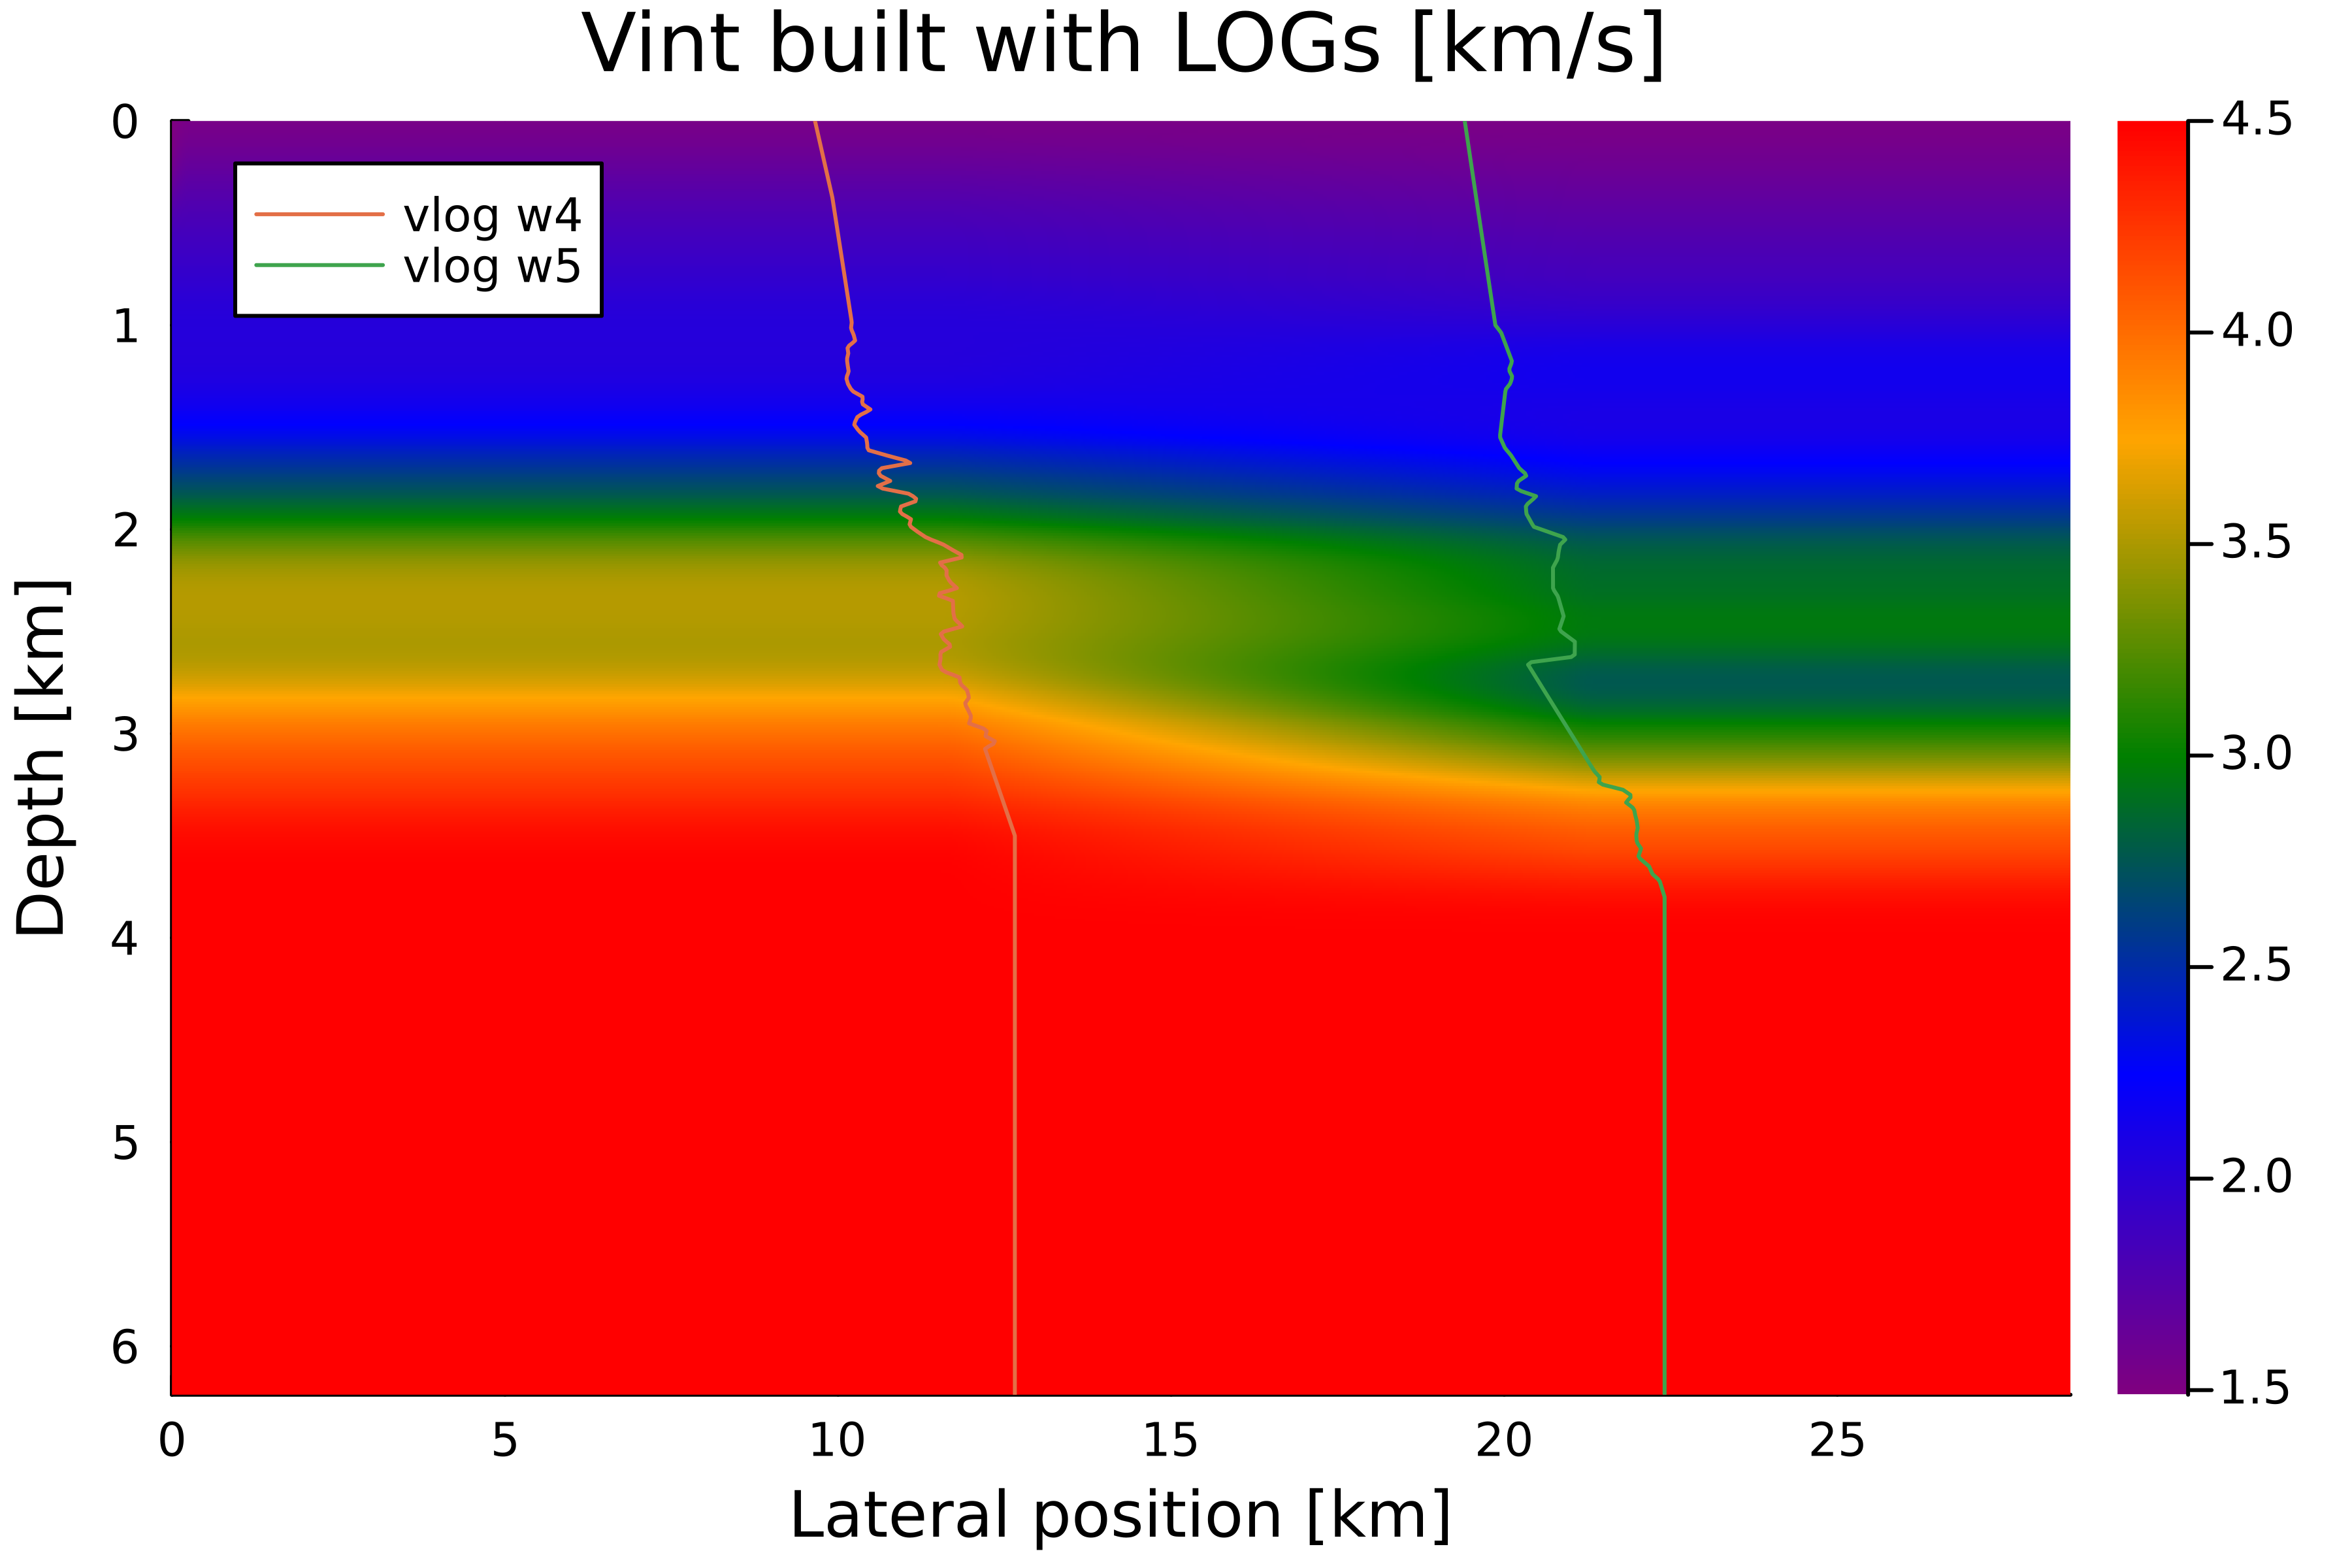

In [22]:
# km/s
w4_blk_z_last = 3.5f0
w4_blk_v_last = 4.5f0
w5_blk_z_last = 3.8f0
w5_blk_v_last = 4.5f0

q_sort_ind = sortperm(w4_blk[1:end,1])
w4_blk_v = w4_blk[q_sort_ind[1:end],2]./1000f0
itp4_v = LinearInterpolation([w4_blk[q_sort_ind[1:end],1]./1000f0; w4_blk_z_last], [w4_blk_v; w4_blk_v_last], extrapolation_bc=w4_blk_v_last)
w4_blk_v = itp4_v(z)

q_sort_ind = sortperm(w5_blk[1:end,1])
w5_blk_v = w5_blk[q_sort_ind,2]./1000f0
itp5_v = LinearInterpolation([w5_blk[q_sort_ind[1:end],1]./1000f0; w5_blk_z_last], [w5_blk_v; w5_blk_v_last], extrapolation_bc=w5_blk_v_last)
w5_blk_v = itp5_v(z)

itp = LinearInterpolation((vcat(x[1], w4_cdp_x, w5_cdp_x, x[end]), z), [w4_blk_v w4_blk_v w5_blk_v w5_blk_v]', extrapolation_bc=Line())
Vlog = itp(x,z)'
seabed_ind = Int.(round.(seabed./dz))
Vlog[1:seabed_ind,] .= vwater
Vlog = imfilter(Vlog, Kernel.gaussian((smooth_radius)))

plt = Plots.heatmap(x, z, Vlog, c=:rainbow, 
  xlims=(x[1],x[end]), 
  ylims=(z[1],z[end]), yflip=true,
  title="Vint built with LOGs [km/s]",
  xlabel="Lateral position [km]",
  ylabel="Depth [km]",
  dpi=600)
Plots.plot!(w4_cdp_x.+w4_blk_v.-mean(w4_blk_v),z, label="vlog w4")
Plots.plot!(w5_cdp_x.+w5_blk_v.-mean(w5_blk_v),z, label="vlog w5")
savefig(plt,model_vlog_png_out)
display(plt)

7) Interpolate density model

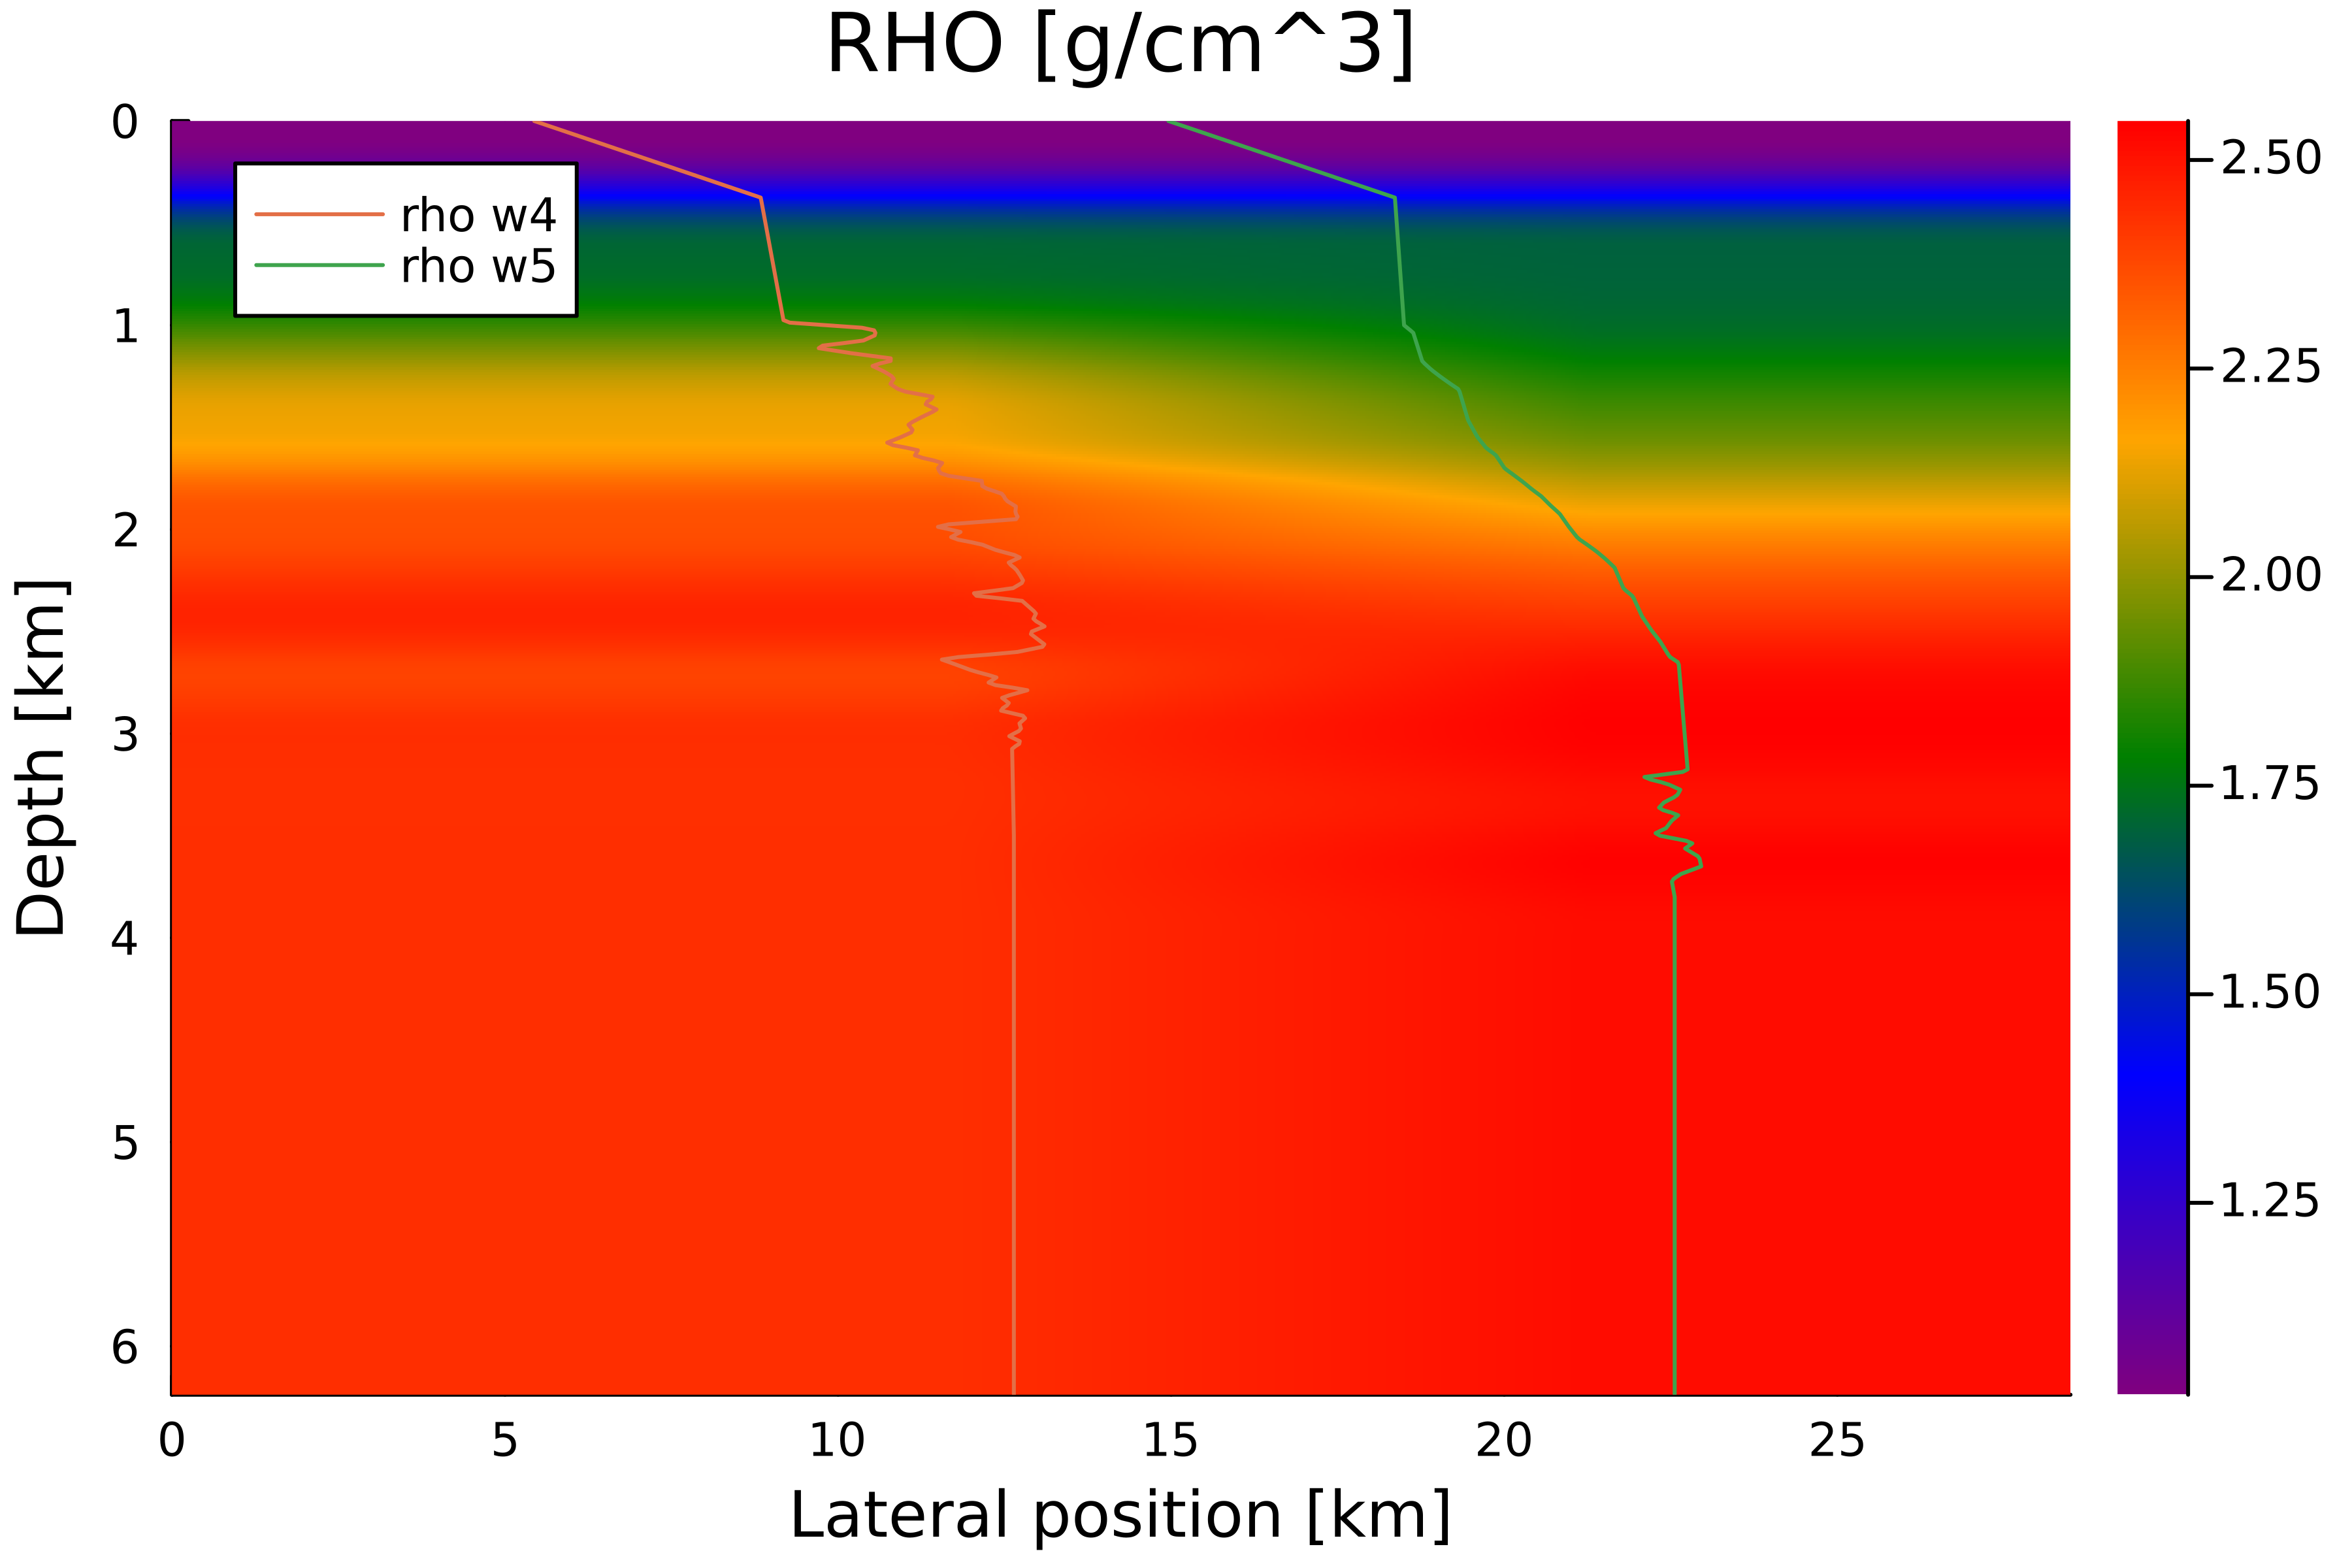

In [24]:
# g/cm^3
w4_blk_z_last = 3.5f0
w4_blk_rho_last = 2.44f0
w5_blk_z_last = 3.8f0
w5_blk_rho_last = 2.52f0

q_sort_ind = sortperm(w4_blk[1:end,1])
w4_blk_rho = w4_blk[q_sort_ind[1:end],4]./1000f0
itp4_rho = LinearInterpolation([w4_blk[q_sort_ind[1:end],1]./1000f0; w4_blk_z_last], [w4_blk_rho; w4_blk_rho_last], extrapolation_bc=w4_blk_rho_last)
w4_blk_rho = itp4_rho(z)

q_sort_ind = sortperm(w5_blk[1:end,1])
w5_blk_rho = w5_blk[q_sort_ind,4]./1000f0
itp5_rho = LinearInterpolation([w5_blk[q_sort_ind[1:end],1]./1000f0; w5_blk_z_last], [w5_blk_rho; w5_blk_rho_last], extrapolation_bc=w5_blk_rho_last)
w5_blk_rho = itp5_rho(z)

itp = LinearInterpolation((vcat(x[1], w4_cdp_x, w5_cdp_x, x[end]), z), [w4_blk_rho w4_blk_rho w5_blk_rho w5_blk_rho]', extrapolation_bc=Line())
RHO = itp(x,z)'
seabed_ind = Int.(round.(seabed./dz))
RHO[1:seabed_ind,:] .= rhowater
RHO = imfilter(RHO, Kernel.gaussian((smooth_radius)))

plt = Plots.heatmap(x, z, RHO, c=:rainbow, 
  xlims=(x[1],x[end]), 
  ylims=(z[1],z[end]), yflip=true,
  title="RHO [g/cm^3]",
  xlabel="Lateral position [km]",
  ylabel="Depth [km]",
  dpi=600)
Plots.plot!(w4_cdp_x.+(w4_blk_rho.-mean(w4_blk_rho)).*5,z, label="rho w4")
Plots.plot!(w5_cdp_x.+(w5_blk_rho.-mean(w5_blk_rho)).*5,z, label="rho w5")
savefig(plt,model_rho_png_out)
display(plt)

8) Make dense model and save results

for this example dense model is the same as original (i.e. `dense_factor=1`). But in general the model may be required denser to achieve stability when solving wave equation.

In [25]:
i_dense = 1:1/Float32(dense_factor):size(Vvsp)[1]
j_dense = 1:1/Float32(dense_factor):size(Vvsp)[2]

vvsp_itp = interpolate(Vvsp, BSpline(Linear()))
Vvsp_dense = vvsp_itp(i_dense, j_dense)

vlog_itp = interpolate(Vlog, BSpline(Linear()))
Vlog_dense = vlog_itp(i_dense, j_dense)

rho_itp = interpolate(RHO, BSpline(Linear()))
RHO_dense = rho_itp(i_dense, j_dense)

# save VINT DEPTH model
fid = h5open(model_file_out, "w")
fid["vvsp"] = permutedims(Vvsp_dense)              # km/s
fid["mvsp"] = (1f0./permutedims(Vvsp_dense)).^2    # (s/km)^2
fid["vlog"] = permutedims(Vlog_dense)              # km/s
fid["mlog"] = (1f0./permutedims(Vlog_dense)).^2    # (s/km)^2
fid["rho"] = permutedims(RHO_dense)             # g/cm^3
fid["n"] = [size(Vvsp_dense)[2], size(Vvsp_dense)[1]]
fid["d"] = [dx*1000f0/dense_factor, dz*1000f0/dense_factor]
fid["o"] = [x[1]*1000f0, z[1]*1000f0]
close(fid)